In [1]:
!pwd

/lustre/home/opacheco/MEDA_Challenge


In [2]:
# Primero desinstala la versión de CPU si la tienes
!pip uninstall -y onnxruntime
# Instala la versión de GPU
!pip install onnxruntime-gpu

You should consider upgrading via the '/lustre/proyectos/p032/env/bin/python -m pip install --upgrade pip' command.


In [3]:
## Importando librerias
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
from torchvision.datasets import ImageFolder
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import random
import copy
import onnxruntime as ort

In [4]:
## Configuracion de Variables
# ========================================================
# NUEVO: Ruta a tu modelo ONNX
# Este modelo actuará como el backbone extractor de características.
PATH_ONNX_MODEL = "models/modelo_chicas.onnx"
# NUEVO: Define el número de características que produce tu modelo ONNX.
# Por ejemplo, para un ResNet-18, esto sería 512.
ONNX_OUTPUT_FEATURES = 6
# ========================================================


# Apunta al directorio raíz del dataset
PATH_DATASET = "/lustre/home/opacheco/MEDA_Challenge/compartido/datasets/daudon_dataset/test"

# Define el número de clases de tu dataset
NUM_CLASES = 6

# Parámetros para el entrenamiento del cabezal
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 1.0 - TRAIN_RATIO - VAL_RATIO
K_SHOTS = 50
EPOCHS = 50 # Ajusta según sea necesario
BATCH_SIZE = 1024 # Ajusta según sea necesario

In [5]:
# --------------------------------------------------------
# 1. FIJAR SEMILLA ALEATORIA
# --------------------------------------------------------
SEED = 46
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [ ]:
# ========================================================
# NUEVO: Helper de tipos de dato (CORREGIDO)
# ========================================================
def get_dtypes_from_onnx(onnx_type_str):
    """
    Mapea un string de tipo de ONNX a sus equivalentes en PyTorch y NumPy.
    """
    if 'float32' in onnx_type_str:
        return torch.float32, np.float32
    elif 'float16' in onnx_type_str:
        return torch.float16, np.float16
    elif 'int64' in onnx_type_str:
        return torch.int64, np.int64
    elif 'int32' in onnx_type_str:
        return torch.int32, np.int32
    
    # Fallback por defecto (el más común)
    print(f"Advertencia: Tipo ONNX no reconocido '{onnx_type_str}', usando float32.")
    return torch.float32, np.float32

# ========================================================
# NUEVO: Clase Wrapper para el Backbone ONNX (Versión GPU CORREGIDA)
# ========================================================
class OnnxBackbone(nn.Module):
    def __init__(self, onnx_path):
        super().__init__()
        print(f"Cargando modelo ONNX para GPU (I/O Binding) desde: {onnx_path}")

        # 1. Asegurarse de que el provider CUDA esté disponible
        if 'CUDAExecutionProvider' not in ort.get_available_providers():
            print("ADVERTENCIA: ONNX Runtime no se compiló con CUDA.")
            print("Asegúrate de haber instalado 'onnxruntime-gpu'.")
            print("Usando 'CPUExecutionProvider' como fallback.")
            self.providers = ['CPUExecutionProvider']
        else:
            self.providers = ['CUDAExecutionProvider']
        
        # 2. Crear la sesión
        self.session = ort.InferenceSession(onnx_path, providers=self.providers)
        
        # 3. Guardar información de I/O
        input_info = self.session.get_inputs()[0]
        output_info = self.session.get_outputs()[0]
        
        self.input_name = input_info.name
        self.output_name = output_info.name
        
        # 4. Obtener y almacenar tipos y formas
        self.input_torch_dtype, self.input_np_dtype = get_dtypes_from_onnx(input_info.type)
        self.output_torch_dtype, self.output_np_dtype = get_dtypes_from_onnx(output_info.type)
        
        self.output_shape = output_info.shape # e.g., ['None', 6]
        
        print(f"✅ Modelo ONNX cargado. Providers: {self.providers}")
        print(f"   Input: '{self.input_name}' (Tipo: {self.input_np_dtype})")
        print(f"   Output: '{self.output_name}' (Tipo: {self.output_np_dtype})")

    def forward(self, x):
        # x es un tensor de PyTorch que ya está en la GPU (x.device)
        
        # Si la sesión no pudo usar CUDA, recurre al método lento
        if 'CUDAExecutionProvider' not in self.session.get_providers():
            x_np = x.cpu().numpy()
            output_np = self.session.run([self.output_name], {self.input_name: x_np})[0]
            return torch.from_numpy(output_np).to(x.device)

        # --- Flujo de I/O Binding (Todo en GPU) ---

        # 1. Asegurarse de que el tensor de entrada esté contiguo
        # y tenga el tipo de dato correcto
        x = x.contiguous().to(self.input_torch_dtype)
        
        # 2. Crear el objeto I/O Binding
        binding = self.session.io_binding()
        
        # 3. Bind del Input (Ahora usa el tipo de dato inferido)
        binding.bind_input(
            name=self.input_name,
            device_type='cuda',
            device_id=x.device.index,
            element_type=self.input_np_dtype, 
            shape=x.shape,
            data_ptr=x.data_ptr()
        )
        
        # 4. Bind del Output (crear un tensor vacío en la GPU)
        
        # Resolver la forma de salida (reemplazar 'None' o dim_param por el batch_size)
        current_output_shape = [x.shape[0] if not isinstance(dim, int) else dim for dim in self.output_shape]
        
        output_tensor = torch.empty(
            tuple(current_output_shape), 
            dtype=self.output_torch_dtype, 
            device=x.device
        ).contiguous()
        
        binding.bind_output(
            name=self.output_name,
            device_type='cuda',
            device_id=output_tensor.device.index,
            element_type=self.output_np_dtype,
            shape=output_tensor.shape,
            data_ptr=output_tensor.data_ptr()
        )
        
        # 5. Ejecutar la inferencia en la GPU
        self.session.run_with_iobinding(binding)
        
        # 6. Devolver el tensor de salida, que ya está poblado y en la GPU
        return output_tensor

In [7]:
# --------------------------------------------------------
# 2. DATASET Y DATALOADERS (Sin cambios)
# --------------------------------------------------------
data_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(0.5),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

try:
    full_dataset = ImageFolder(PATH_DATASET, transform=data_transform)
    print(f"Dataset cargado: {len(full_dataset)} imágenes en {len(full_dataset.classes)} clases.")
    NUM_CLASES = len(full_dataset.classes)
except FileNotFoundError:
    print(f"Error: No se encontró el directorio {PATH_DATASET}")
    raise

# División estratificada del dataset
targets = full_dataset.targets
indices = list(range(len(targets)))
train_indices, val_test_indices, train_targets, val_test_targets = train_test_split(
    indices, targets, train_size=TRAIN_RATIO, stratify=targets, random_state=SEED)
test_split_ratio = TEST_RATIO / (VAL_RATIO + TEST_RATIO)
val_indices, test_indices = train_test_split(
    val_test_indices, test_size=test_split_ratio, stratify=val_test_targets, random_state=SEED)

train_dataset = Subset(full_dataset, train_indices)
val_dataset = Subset(full_dataset, val_indices)
test_dataset = Subset(full_dataset, test_indices)

val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

# Creación del dataset Few-Shot
print(f"Creando Support Set de {K_SHOTS}-shot...")
support_indices = []
for c in range(NUM_CLASES):
    class_indices = [i for i, t in zip(train_indices, train_targets) if t == c]
    if len(class_indices) < K_SHOTS:
        k_shot_indices = class_indices
    else:
        k_shot_indices = random.sample(class_indices, K_SHOTS)
    support_indices.extend(k_shot_indices)

few_shot_dataset = Subset(full_dataset, support_indices)
few_shot_train_loader = DataLoader(few_shot_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
print(f"DataLoader Few-Shot creado con {len(few_shot_dataset)} imágenes.")

Dataset cargado: 2400 imágenes en 6 clases.
Creando Support Set de 50-shot...
DataLoader Few-Shot creado con 300 imágenes.


/lustre/proyectos/p032/env/lib64/python3.9/site-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 2 worker processes in total. Our suggested max number of worker in current system is 1, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
# --------------------------------------------------------
# 3. CABEZAL DE CLASIFICACIÓN (Adaptado para recibir cualquier backbone)
# --------------------------------------------------------
class ClassificationModel(nn.Module):
    def __init__(self, backbone, num_features, num_classes):
        super().__init__()
        # El backbone será nuestro modelo ONNX envuelto en la clase OnnxBackbone
        self.backbone = backbone

        # Cabezal de clasificación (solo estas capas serán entrenadas)
        self.linear_head = nn.Sequential(
            nn.Linear(num_features, 256),
            nn.LayerNorm(256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.25),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        # Extraer características con el backbone (SIN calcular gradientes para él)
        with torch.no_grad():
            feats = self.backbone(x)
        
        # Aplanar las características para el cabezal lineal
        feats = feats.view(feats.size(0), -1)
        
        # Pasar las características por el cabezal que sí se entrena
        out = self.linear_head(feats)
        return out
    
# === Configuración del modelo con ONNX ===
# 1. Instanciar el backbone ONNX
onnx_backbone = OnnxBackbone(PATH_ONNX_MODEL)

# 2. Crear el modelo de clasificación completo
model = ClassificationModel(
    backbone=onnx_backbone,
    num_features=ONNX_OUTPUT_FEATURES,
    num_classes=NUM_CLASES
).to(DEVICE)

# 3. Configurar pérdida y optimizador
# El optimizador solo actualizará los pesos del `linear_head`
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.linear_head.parameters(), lr=3e-3, weight_decay=1e-4)

Cargando modelo ONNX para GPU (I/O Binding) desde: models/modelo_chicas.onnx


2025-11-05 01:22:28.610142597 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 176110, index: 6, mask: {19, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-11-05 01:22:28.613931302 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 176111, index: 7, mask: {20, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-11-05 01:22:28.618945134 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 176112, index: 8, mask: {21, }, error code: 22 error msg: Invalid argument. Specify the number of threads explicitly so the affinity is not set.
2025-11-05 01:22:28.620981388 [E:onnxruntime:Default, env.cc:234 ThreadMain] pthread_setaffinity_np failed for thread: 176113, index: 9, mask: {22, }, error code: 22 error msg: Invalid argument. Specify the n

Advertencia: Tipo ONNX no reconocido 'tensor(float)', usando float32.
Advertencia: Tipo ONNX no reconocido 'tensor(float)', usando float32.
✅ Modelo ONNX cargado. Providers: ['CUDAExecutionProvider']
   Input: 'images' (Tipo: <class 'numpy.float32'>)
   Output: 'logits6' (Tipo: <class 'numpy.float32'>)


: 

In [9]:
# --------------------------------------------------------
# 4. ENTRENAMIENTO (Sin cambios en la lógica)
# --------------------------------------------------------
print("\n🚀 Iniciando entrenamiento del cabezal de clasificación con backbone ONNX...")

best_val_acc = 0.0
best_weights = None
patience = 30
wait = 0

for epoch in range(EPOCHS):
    model.train() # Pone en modo de entrenamiento solo el cabezal
    running_loss = 0.0

    for inputs, labels in few_shot_train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    epoch_loss = running_loss / len(few_shot_train_loader.dataset)

    # Validación
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_acc = 100 * correct / total

    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {epoch_loss:.4f} - Val Acc: {val_acc:.2f}%")

    # Early stopping y guardado del mejor modelo
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_weights = copy.deepcopy(model.state_dict())
        wait = 0
    else:
        wait += 1
        if wait >= patience:
            print(f"⏹ Early stopping en epoch {epoch+1}")
            break

print("Entrenamiento finalizado.")
if best_weights:
    model.load_state_dict(best_weights)
    print(f"✅ Mejor modelo cargado con Val Acc: {best_val_acc:.2f}%")


🚀 Iniciando entrenamiento del cabezal de clasificación con backbone ONNX...


: 

: 


🧪 Evaluando en el set de testeo...

🎉 ¡Evaluación con Backbone ONNX completa! 🎉
   Accuracy en test: 25.83 %


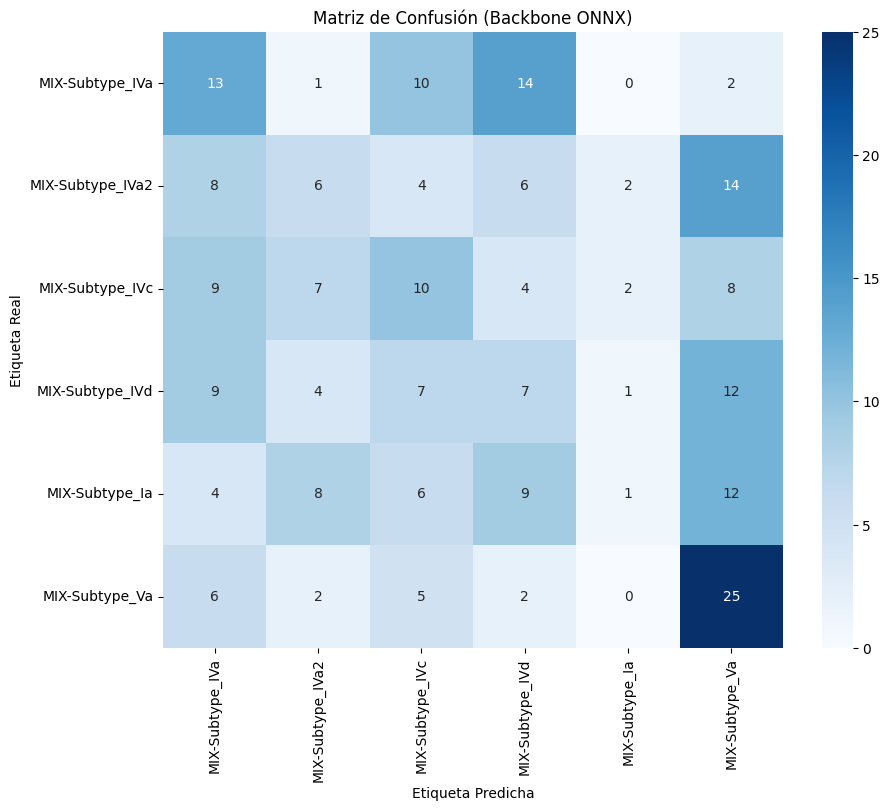

In [ ]:
# --------------------------------------------------------
# 5. EVALUACIÓN FINAL Y MATRIZ DE CONFUSIÓN
# --------------------------------------------------------
print("\n🧪 Evaluando en el set de testeo...")
model.eval()
all_labels, all_preds = [], []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())

accuracy = 100 * (np.array(all_preds) == np.array(all_labels)).sum() / len(all_labels)
print("\n========================================================")
print(f"🎉 ¡Evaluación con Backbone ONNX completa! 🎉")
print(f"   Accuracy en test: {accuracy:.2f} %")
print("========================================================")

# Matriz de Confusión
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=full_dataset.classes, yticklabels=full_dataset.classes)
plt.title('Matriz de Confusión (Backbone ONNX)')
plt.ylabel('Etiqueta Real')
plt.xlabel('Etiqueta Predicha')
plt.show()